# Load YOLOV8 model

In [1]:
# Load YOLO model
from ultralytics import YOLO

MODEL_PATH = "runs/detect/train4/weights/best.pt"
model = YOLO(MODEL_PATH)

print(f"✅ YOLO model loaded: {MODEL_PATH}")

# Load metrics performance .jpg and .png data files from validation files
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

METRICS_DIR = "runs/detect/val2"
jpg_files = [f for f in os.listdir(METRICS_DIR) if f.endswith('.jpg')]
png_files = [f for f in os.listdir(METRICS_DIR) if f.endswith('.png')]
metrics_files = jpg_files + png_files
metrics_files.sort()  # Sort files for consistent order
print(f"✅ Found {len(metrics_files)} metrics files in {METRICS_DIR}")

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train4/weights/best.pt'

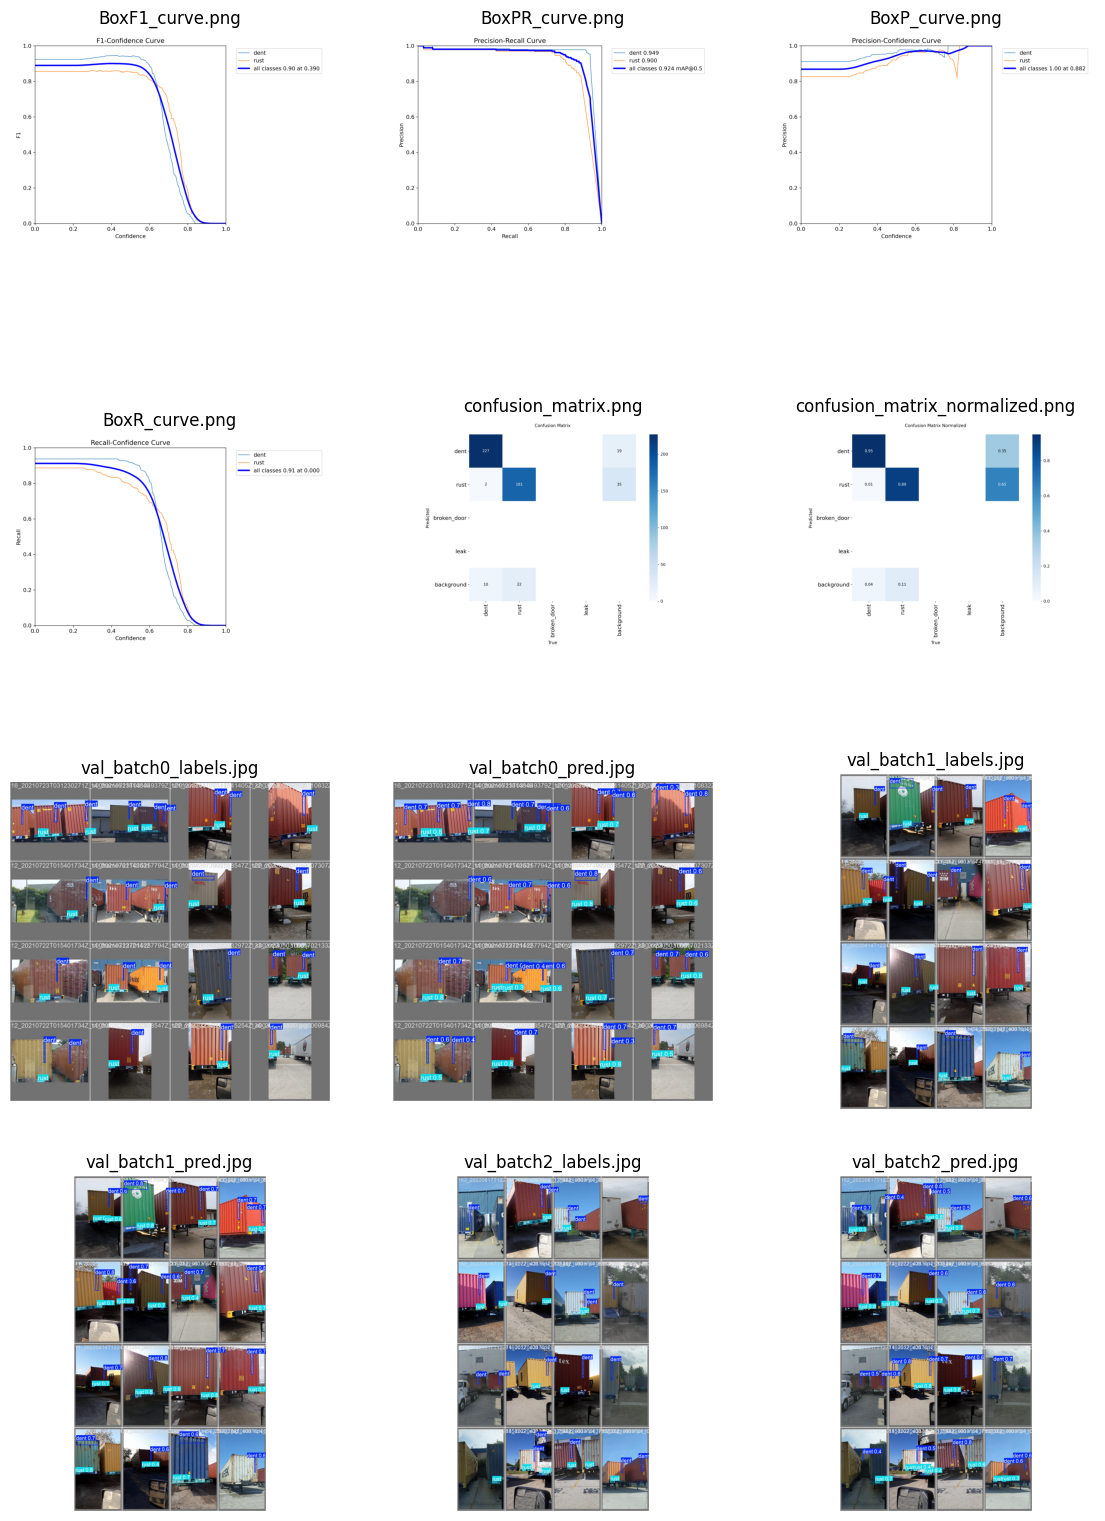

In [ ]:
# Show each metrics performance file into a matplotlib window with 3 x 3 grid
num_files = len(metrics_files)
num_cols = 3
num_rows = (num_files + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5 * num_rows))
axes = axes.flatten()  # Flatten to easily iterate over axes
for idx, file_name in enumerate(metrics_files):
    img_path = os.path.join(METRICS_DIR, file_name)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(file_name)
    axes[idx].axis('off')

# Real time video live container damage detection
- Ingest video from youtube
- Ensure the video is reliable with YOLOV8 model are trained
- YOLOV8 Custom Model (the trained weights)
- Live detection overlay
- Risk Engine + RAG Trigger (optional)

# Extract direct video stream

In [ ]:
import subprocess
import json

# Extract direct video stream
def get_stream_url(youtube_url):
    cmd = [
        "yt-dlp",
        "-f",
        "best[ext=mp4]",
        "-g",
        youtube_url
    ]
    stream_url = subprocess.check_output(cmd).decode().strip()
    return stream_url

# Download YouTube Video (Recommended)

In [ ]:
import cv2

# Use local video file
VIDEO_PATH = "dataset/videos/container_video.mov"

try:
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    if not cap.isOpened():
        raise Exception(f"Cannot open video file: {VIDEO_PATH}")
    
    # Get video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"✅ Video loaded: {VIDEO_PATH}")
    print(f"   - Resolution: {width}x{height}")
    print(f"   - FPS: {fps}")
    print(f"   - Total frames: {total_frames}")
        
except Exception as e:
    print(f"❌ Failed to open video: {e}")

✅ Video loaded: dataset/videos/container_video.mov
   - Resolution: 2940x1912
   - FPS: 47
   - Total frames: 9784


# Real-Time performance optimation

In [ ]:
import numpy as np
import cv2

VIDEO_PATH = "dataset/videos/container_video.mov"
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"❌ Cannot open video: {VIDEO_PATH}")
else:
    print(f"✅ Video reopened for fast processing")
    
frame_count = 0
detection_count = 0
frame_skip = 4

cv2.namedWindow("FAST CONTAINER DETECTION", cv2.WINDOW_NORMAL)

while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        print("⚠️ End of video")
        break

    frame_count += 1
    # Skip frames for faster processing
    if frame_count % frame_skip != 0:
        continue

    results = model.predict(
        source=frame,
        imgsz=1280, # High resolution: Can watch a object from far distance
        conf=0.15,
        iou=0.50, # Higher IOU: Allowed box overlap (important for bunch of containers)
        max_det=1000, # increase max detections for crowded scenes
        classes=None, # changeable to specific classes if needed (e.g., can be set to ID class, example: [0] for class definition)
        agnostic_nms=True, # class-agnostic NMS for increased speed

        stream=False, # flexible stream if we want to save later (set to False if want to save video, True if just processing and not saving)
        vid_stride=2, # vid_stride for faster video processing 
        batch=1,

        device="mps",
        half=True, # Use FP16 for speedup on Apple Silicon (MPS)

        show=False,
        save=False,
        verbose=True
    )

    # Visualize & Data Extraction
    annotated_frame = results[0].plot()
    boxes = results[0].boxes
    num_detections = len(boxes)
    detection_count += num_detections

    # Overlay info UI
    info_text = f"Frame: {frame_count} | Det: {num_detections} | Total: {detection_count} | SPEED x{frame_skip}"
    cv2.rectangle(annotated_frame, (5, 5), (750, 45), (0, 0, 0), -1)
    cv2.putText(annotated_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Instruction UI
    instruction_text = "ESC/Q=Exit | SPACE=Pause | X (window)=Close"
    cv2.rectangle(annotated_frame, (5, annotated_frame.shape[0]-35), (500, annotated_frame.shape[0]-5), (0, 0, 0), -1)
    cv2.putText(annotated_frame, instruction_text, (10, annotated_frame.shape[0]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("FAST CONTAINER DETECTION", annotated_frame)

    # Handle Keyboard & Window Controls
    if cv2.getWindowProperty("FAST CONTAINER DETECTION", cv2.WND_PROP_VISIBLE) < 1:
        print("⚠️ Window closed by user (X button)")
        break

    key = cv2.waitKey(1) & 0xFF

    # Check waitkey (for MacOS)
    if cv2.getWindowProperty("FAST CONTAINER DETECTION", cv2.WND_PROP_VISIBLE) < 1:
        print("⚠️ Window closed by user (X button)")
        break

    if key == 27:
        print("⚠️ ESC pressed - Exiting...")
        break
    elif key == ord('q') or key == ord('Q'):
        print("⚠️ Q pressed - Exiting...")
        break
    elif key == 32:
        print("⏸️  PAUSED - Press any key to continue...")
        cv2.waitKey(0)

cap.release()
cv2.destroyAllWindows()

# Final Metrics Report
print(f"\n--- LOG REPORT ---")
print(f"✅ Fast processing complete!")
print(f"   - Total frames processed: {frame_count}")
print(f"   - Frames analyzed: {frame_count // frame_skip}")
print(f"   - Total detections: {detection_count}")
if frame_count > 0:
    print(f"   - Avg containers/frame: {detection_count/(frame_count//frame_skip):.2f}")
print(f"   - Speed multiplier: x{frame_skip}")

✅ Video reopened for fast processing
⚠️ End of video

--- LOG REPORT ---
✅ Fast processing complete!
   - Total frames processed: 9774
   - Frames analyzed: 3258
   - Total detections: 3949
   - Avg containers/frame: 1.21
   - Speed multiplier: x3


# DAMAGE COUNTER Overlay

In [ ]:
CLASS_MAP = {
    0: "dent",
    1: "rust",
    2: "broken_door",
    3: "leak"
}

def extract_counts(result):
    counts = {"dent":0, "rust":0, "broken_door":0, "leak":0}
    boxes = result.boxes

    for cls in boxes.cls:
        name = CLASS_MAP[int(cls)]
        counts[name] += 1

    return counts

# Add loop after inference
result = results[0]
counts = extract_counts(result)
text = f"Dent:{counts['dent']} Rust:{counts['rust']} Broken Door:{counts['broken_door']} Leak:{counts['leak']}"

cv2.putText(annotated_frame,text,
            (20,40),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,(0,255,0), 2)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]]], shape=(1912, 2940, 3), dtype=uint8)

# REAL BUSINESS MODE — Risk Trigger

In [ ]:
severity = (
    counts['dent']*1 +
    counts['rust']*2 +
    counts['broken_door']*3 +
    counts['leak']*4
)

if severity >= 4:
    print("⚠️ High risk container detected! Triggering alert...")
    # Here you can add code to send an alert (e.g., email, SMS, webhook)

# Damage counter overlay

In [ ]:
# Create damage counter overlay for no GUI
import numpy as np
import cv2

CLASS_MAP = {
    0: "dent",
    1: "rust",
    2: "broken_door",
    3: "leak"
}

def extract_counts_noGUI(result):
    counts = {"dent":0, "rust":0, "broken_door":0, "leak":0}
    boxes = result.boxes

    for classes in boxes.cls:
        name = CLASS_MAP[int(classes)]
        counts[name] += 1

    return counts

# Add loop after inference
result = results[0]
counts = extract_counts_noGUI(result)
text= f"Dent:{counts['dent']} Rust:{counts['rust']} Broken Door:{counts['broken_door']} Leak:{counts['leak']}"

cv2.putText(annotated_frame,text,
            (20,40),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,(0,255,0), 2)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]],

       [[19, 19, 19],
        [19, 19, 19],
        [19, 19, 19],
        ...,
        [22, 22, 22],
        [22, 22, 22],
        [22, 22, 22]]], shape=(1912, 2940, 3), dtype=uint8)

# REAL BUSINESS MODE — Risk Trigger

In [ ]:
severity = (
    counts['dent']*1 +
    counts['rust']*2 +
    counts['broken_door']*3 +
    counts['leak']*4
)

if severity >= 4:
    print("⚠️ High risk container detected! Triggering alert inspect now!...")
    # Here you can add code to send an alert (e.g., email, SMS, webhook)

# RAG Experimennt Layer

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("dataset/Pdf/Standard_container_operations.pdf") # SOP document for container getting authorized by STANDARDS FOR EMPTY SHIPPING CONTAINER INSPECTION VERSION 2 - May 2021
docs = loader.load()

print(f"✅ Loaded {len(docs)} pages from SOP document")

/Users/miftahhadiyannoor/Documents/logistics-rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 75 pages from SOP document


# Create Vector DB

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embed = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_documents(docs, embed)
db.save_local("faiss_container_sop_db")

print(f"✅ Vector database created and saved!")
print(f"   - Total documents: {len(docs)}")
print(f"   - Embedding model: sentence-transformers/all-MiniLM-L6-v2")
print(f"   - Database saved to: faiss_container_sop_db/")

/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_61726/3490813910.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embed = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 706.52it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Vector database created and saved!
   - Total documents: 75
   - Embedding model: sentence-transformers/all-MiniLM-L6-v2
   - Database saved to: faiss_container_sop_db/


# Prompting Using CV Result

In [ ]:
prompting = f"""
Inspection result:
Dent: {counts['dent']}
Rust: {counts['rust']}
Broken Door: {counts['broken_door']}
Leak: {counts['leak']}
Severity Score: {severity}

What operational action must be taken?"""

context = db.similarity_search(query=prompting, k=3)

# REAL BUSINESS MODE — Risk Trigger (noGUI version)

In [ ]:
severity = (
    counts['dent']*1 +
    counts['rust']*2 +
    counts['broken_door']*3 +
    counts['leak']*4
)

if severity >= 4:
    print("⚠️ High risk container detected! Triggering alert inspect now!...")
    # Here you can add code to send an alert (e.g., email, SMS, webhook)

# RAG Experiment Layer
# AI Engineer concept to explainn why the container are
- 0. rust, 
- 1. dent, 
- 2. broken_door, 
- 3. leak

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("dataset/Pdf/Standard_container_operations.pdf") # SOP document for container getting authorized by STANDARDS FOR EMPTY SHIPPING CONTAINER INSPECTION VERSION 2 - May 2021
docs = loader.load()

print(f"✅ Loaded {len(docs)} pages from SOP document")

✅ Loaded 75 pages from SOP document


# Create Vector DB

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embed = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_documents(docs, embed)
db.save_local("faiss_container_sop_db")

print(f"✅ Vector database created and saved!")
print(f"   - Total documents: {len(docs)}")
print(f"   - Embedding model: sentence-transformers/all-MiniLM-L6-v2")
print(f"   - Database saved to: faiss_container_sop_db/")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2382.55it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Vector database created and saved!
   - Total documents: 75
   - Embedding model: sentence-transformers/all-MiniLM-L6-v2
   - Database saved to: faiss_container_sop_db/


# Prompting Using CV Result

In [ ]:
prompting = f"""
Inspection result:
Dent: {counts['dent']}
Rust: {counts['rust']}
Broken Door: {counts['broken_door']}
Leak: {counts['leak']}
Severity Score: {severity}

What operational action must be taken?"""

context = db.similarity_search(query=prompting, k=3)

# AI Engineer prompt to get business problem solution

In [ ]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama3")

final_prompt = f"""
You are senior port inspection Engineer.
Based on the container inspection results and the following SOP context, provide a concise recommendation for operational action.

context:
{context}

Inspection Results:
{prompting}

Generate:
- Risk Level
- Action Recommendation
- Repair Urgency
- Report Summary
"""

print("🤖 Generating AI recommendation...")
response = llm.invoke(final_prompt)  # Fix: llm() -> llm.invoke()
print("\n" + "="*60)
print(response)
print("="*60)

/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_61726/2431376765.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3")


🤖 Generating AI recommendation...

Based on the inspection results, I recommend the following:

**Risk Level:** Low

The inspection result shows no rust, dents, broken doors, leaks, or severity score. This indicates that the container is in a good condition with no significant defects or issues.

**Action Recommendation:** Acceptance of Container

Given the inspection results, it appears that the container meets the required standards for DAWE certified containers. Therefore, I recommend accepting the container and allowing it to proceed for its intended use.

**Repair Urgency:** None

There are no identified defects or issues that require immediate repair or attention.

**Report Summary:**

The container has been inspected and found to be in good condition with no significant defects or issues. The inspection results show a severity score of 0, indicating no rust, dents, broken doors, leaks, or other problems. Based on these findings, the container is recommended for acceptance and ca

# Financial Estimation Layer

In [ ]:
repair_cost = (
    counts['dent'] * 200 +
    counts['rust'] * 300 +
    counts['broken_door'] * 500 +
    counts['leak'] * 750
)

print("Estimated Repair Cost Analysis:", repair_cost)

Estimated Repair Cost Analysis: 0


# Production Version (no GUI)

In [ ]:
# ✅ Production Version - OPTIMIZED (Streaming + Memory-Efficient)
import gc

VIDEO_PATH = "dataset/videos/container_video.mov"

print("=" * 70)
print("PRODUCTION MODE - Memory Optimized Streaming")
print("=" * 70)

# Use stream=True to process frames one at a time
results_gen = model.predict(
    source=VIDEO_PATH,
    stream=True,  # ✅ IMPORTANT: Stream mode = ~100MB RAM instead of 23GB!
    verbose=False,
    conf=0.20,
    imgsz=640,
    device="mps",
    half=True
)

frame_count = 0
total_damage_detections = 0
damage_summary = {"dent": 0, "rust": 0, "broken_door": 0, "leak": 0}

print("\n🔄 Processing video stream...\n")

# Process each frame as it comes (streaming)
for result in results_gen:
    frame_count += 1
    boxes = result.boxes
    num_detections = len(boxes)
    
    if num_detections > 0:
        total_damage_detections += num_detections
        
        # Extract damage counts
        for cls in boxes.cls:
            damage_type = CLASS_MAP.get(int(cls), "unknown")
            damage_summary[damage_type] += 1
        
        # Print progress every 100 frames
        if frame_count % 100 == 0:
            print(f"Frame {frame_count}: {num_detections} detections | "
                  f"Total: {total_damage_detections} | "
                  f"Memory cleanup...")
            gc.collect()  # Force garbage collection every 100 frames
    
    # Don't store frames! Process and discard immediately
    # frame = None  # Already happens when generator moves to next
    
    # Stop after first 1000 frames for demo (remove for full video)
    # if frame_count >= 1000:
    #     print("\n⏹️  Demo stopped after 1000 frames")
    #     break

print("\n" + "=" * 70)
print("✅ PRODUCTION REPORT - Memory Efficient")
print("=" * 70)
print(f"Total frames processed: {frame_count}")
print(f"Total damages detected: {total_damage_detections}")
print(f"Average detections/frame: {total_damage_detections/frame_count:.2f}")
print(f"\nDamage Breakdown:")
for damage_type, count in damage_summary.items():
    print(f"  - {damage_type.title()}: {count}")

# Calculate risk level
severity_score = (
    damage_summary['dent'] * 1 +
    damage_summary['rust'] * 2 +
    damage_summary['broken_door'] * 3 +
    damage_summary['leak'] * 4
)

risk_level = "🟢 LOW" if severity_score < 50 else "🟡 MEDIUM" if severity_score < 200 else "🔴 HIGH"
print(f"\nRisk Level: {risk_level}")
print(f"Severity Score: {severity_score}")
print("=" * 70)


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 (no detections), 1386.8ms
video 1/1 (frame 2/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 (no detections), 24.9ms
video 1/1 (frame 3/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 1 rust, 25.9ms
video 1/1

KeyboardInterrupt: 